<a href="https://colab.research.google.com/github/JSravanreddy/ML-projects/blob/main/ProjectSegmentationInsulatorstot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Segmentation
Segmentation is performed using Unet.
Classification is implemented in part 2.

In [1]:
from google.colab import drive
drive.mount('/content/drive')
# drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [2]:

import os, math
import matplotlib.pyplot as plt
import numpy as np
import skimage
from skimage import io
from tqdm import tqdm               
from PIL import Image
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset, DataLoader
device = "cuda"

import torchvision
from torchvision import transforms
import glob
import pathlib
from albumentations import (
    PadIfNeeded,
    HorizontalFlip,
    VerticalFlip,    
    CenterCrop,    
    Crop,
    Compose,
    Transpose,
    RandomRotate90,
    ElasticTransform,
    GridDistortion, 
    OpticalDistortion,
    RandomSizedCrop,
    OneOf,
    CLAHE,
    RandomBrightnessContrast,    
    RandomGamma    
)

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


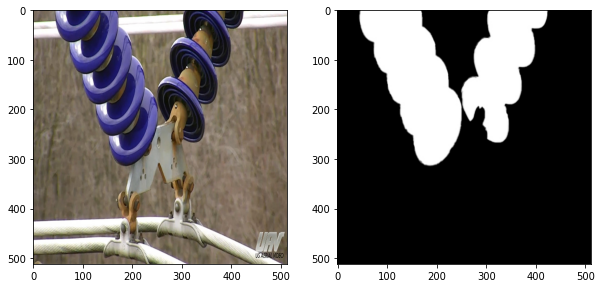

In [4]:
import cv2
data_path_seg = 'Dataset/Segmentation'
data_path_class = 'Dataset/Classification'

# Insulators

plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
im = io.imread(os.path.join("/content/drive/MyDrive/Transmission line insulators/Dataset/Dataset/Segmentation/train/in/20015.jpg"))
plt.imshow(im)
plt.subplot(1,2,2)
mask = skimage.img_as_ubyte(io.imread(os.path.join("/content/drive/MyDrive/Transmission line insulators/Dataset/Dataset/Segmentation/train/gt/20015.jpg")))
plt.imshow(mask)

In [30]:
# Intersection over union

def calc_iou(prediction, ground_truth):
    n_images = len(prediction)
    intersection, union = 0, 0
    for i in range(n_images):
        intersection += np.logical_and(prediction[i] > 0, ground_truth[i] > 0).sum().float()
        union += np.logical_or(prediction[i] > 0, ground_truth[i] > 0).sum().float()
    return (intersection) / union

def calc_iou_torch(prediction, ground_truth):
    n_images = len(prediction)
    intersection, union = 0, 0
    for i in range(n_images):
        intersection += torch.sum(torch.mul(prediction, ground_truth))
        union += torch.sum(torch.max(prediction, ground_truth))
    #print("is: ", intersection, ",un: ", union)
    return torch.div(intersection,union)

In [5]:
class SegTrainDataset(Dataset):
    def __init__(self,transform = None, data_path = ""): 
        self.path1 = sorted(glob.glob(os.path.join("/content/drive/MyDrive/Transmission line insulators/Dataset/Dataset/Segmentation/train/in/*.jpg")))
        self.path2 = sorted(glob.glob(os.path.join("/content/drive/MyDrive/Transmission line insulators/Dataset/Dataset/Segmentation/train/gt/*.jpg")))
        assert len(self.path1) == len(self.path2)
        self.transform = transform
    def __getitem__(self, index):
        sample  = cv2.imread(self.path1[index])
        sample1 = cv2.imread(self.path2[index], 0)
        if self.transform is not None:
            augmented = self.transform(image = sample, mask = sample1)
            sample =  torch.tensor(augmented['image'], dtype = torch.float32) / 255
            sample1 = torch.tensor(augmented['mask'], dtype = torch.float32) / 255
        # sample1.unsqueeze_(0)
        # photo_image, map_image = torch.chunk(sample, chunks=2, dim=2)
        
        return sample, sample1
    def __len__(self):
        return len(self.path1)

class SegValDataset(Dataset):
    def __init__(self,transform = None, data_path = ""): 
        self.path1 = sorted(glob.glob(os.path.join("/content/drive/MyDrive/Transmission line insulators/Dataset/Dataset/Segmentation/val/in/*.jpg")))
        self.path2 = sorted(glob.glob(os.path.join("/content/drive/MyDrive/Transmission line insulators/Dataset/Dataset/Segmentation/val/gt/*.jpg")))
        self.transform=transform
    def __getitem__(self, index):
        sample = cv2.imread(self.path1[index])
        sample1=cv2.imread(self.path2[index], 0)
        if self.transform is not None:
            augmented = self.transform(image=sample, mask=sample1)
            sample  =  torch.tensor(augmented['image'],dtype=torch.float32) / 255
            sample1 = torch.tensor(augmented['mask'],dtype=torch.float32) / 255
        
        return sample, sample1
    def __len__(self):
        return len(self.path1)

In [6]:
transform = Compose([ 
    VerticalFlip(p=0.5),              
    RandomRotate90(p=0.5),
    OneOf([
        ElasticTransform(p = 0.5, alpha = 120, sigma = 120 * 0.05, alpha_affine = 120 * 0.03),
        GridDistortion(p = 0.5),
        #OpticalDistortion(p = 1, distort_limit = 2, shift_limit = 0.5)                  
        ], p = 0.8),
    CLAHE(p = 0.8),
    RandomBrightnessContrast(p = 0.8),    
    RandomGamma(p = 0.8)])
n1 = 3
n2 = 2
transform1 = Compose([               
    RandomRotate90(p = 0.0005),
  ])

train_dataset = SegTrainDataset(transform = transform, data_path = data_path_seg)
val_dataset = SegValDataset(transform = transform1, data_path = data_path_seg)
train_loader = DataLoader(train_dataset, batch_size = n1, shuffle = True, num_workers = 0)
val_loader = DataLoader(val_dataset, batch_size = len(val_dataset), shuffle = False, num_workers = 0)

In [11]:
for i in val_loader:
  print(i)
  break

[tensor([[[[0.4235, 0.4902, 0.5725],
          [0.4157, 0.4824, 0.5647],
          [0.3961, 0.4627, 0.5373],
          ...,
          [0.3725, 0.4549, 0.5373],
          [0.4118, 0.4941, 0.5765],
          [0.4157, 0.4980, 0.5804]],

         [[0.4000, 0.4667, 0.5490],
          [0.3961, 0.4627, 0.5451],
          [0.3804, 0.4471, 0.5216],
          ...,
          [0.4039, 0.4863, 0.5686],
          [0.3922, 0.4745, 0.5569],
          [0.3882, 0.4706, 0.5529]],

         [[0.4000, 0.4667, 0.5490],
          [0.4000, 0.4667, 0.5490],
          [0.3882, 0.4549, 0.5294],
          ...,
          [0.4196, 0.4941, 0.5765],
          [0.3961, 0.4706, 0.5529],
          [0.3961, 0.4706, 0.5529]],

         ...,

         [[0.1922, 0.2627, 0.2902],
          [0.2118, 0.2824, 0.3098],
          [0.2353, 0.3059, 0.3333],
          ...,
          [0.2863, 0.4157, 0.4510],
          [0.2510, 0.3765, 0.4196],
          [0.2314, 0.3686, 0.4078]],

         [[0.1961, 0.2667, 0.2941],
          [0.215

In [12]:
root=pathlib.Path("/content/drive/MyDrive/Transmission line insulators/Dataset/Dataset/Classification/train")
classes=sorted([j.name.split('/')[-1] for j in root.iterdir()])

In [13]:
print(classes)

['0_healthy', '1_broken_cap', '2_burned_corrosion', '3_missing_cap']


In [14]:
print(len(val_dataset))
print(len(train_dataset))

14
105


In [7]:
class UnetDownBlock(nn.Module):
    def __init__(self, in_channels, out_channels, pooling = True):
        super().__init__()
        
        self.convReLU = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size = 3, padding = 1),
            nn.ReLU(),
        )
        self.maxpool = nn.MaxPool2d(kernel_size = 2)
        
    def forward(self, seq):
        # B, C, H, W

        bridge = self.convReLU(seq)
        seq = self.maxpool(bridge)

        return seq, bridge
    
class UnetUpBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        self.upsample = nn.Upsample(scale_factor = 2)
        self.convReLU = nn.Sequential(
            nn.Conv2d(in_channels * 2, out_channels, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size = 3, padding = 1),
            nn.ReLU(),
        )
        
    def forward(self, seq, bridge):
        # seq:    B, C, H / 2, W / 2
        # bridge: B, C, H, W
        
        seq = self.upsample(seq)
        concat = torch.cat([seq, bridge], dim = 1)
        
        return self.convReLU(concat)


class UNet(nn.Module):
    def __init__(self):
      super().__init__()

      nb = 16

      self.downBlocks = nn.ModuleList()
      self.downBlocks.append(UnetDownBlock(3, nb))
      self.downBlocks.append(UnetDownBlock(nb, nb * 2))
      self.downBlocks.append(UnetDownBlock(nb * 2, nb * 4))
      self.downBlocks.append(UnetDownBlock(nb * 4, nb * 8))
      self.downBlocks.append(UnetDownBlock(nb * 8, nb * 16))

      self.upBlocks = nn.ModuleList()
      self.upBlocks.append(UnetUpBlock(nb * 16, nb * 8))
      self.upBlocks.append(UnetUpBlock(nb * 8, nb * 4))
      self.upBlocks.append(UnetUpBlock(nb * 4, nb * 2))
      self.upBlocks.append(UnetUpBlock(nb * 2, nb))
      self.upBlocks.append(UnetUpBlock(nb, 3))

      self.finalConv = nn.Sequential(nn.Conv2d(3, 1, kernel_size = 3, padding = 1),
                                     nn.Sigmoid())
      
    def forward(self, input):
        
        bridges = []
        for db in self.downBlocks:
          input, bridge = db(input)
          bridges.append(bridge)
        
        bridge_id = len(bridges) - 1
        for ub in self.upBlocks:
          input = ub(input, bridges[bridge_id])
          bridge_id -= 1

        input = self.finalConv(input)
        input = input[:,0,:,:]

        return input

In [8]:
from torchsummary import summary
summary(UNet().cuda(), (3,512,512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 512, 512]             448
              ReLU-2         [-1, 16, 512, 512]               0
            Conv2d-3         [-1, 16, 512, 512]           2,320
              ReLU-4         [-1, 16, 512, 512]               0
         MaxPool2d-5         [-1, 16, 256, 256]               0
     UnetDownBlock-6  [[-1, 16, 256, 256], [-1, 16, 512, 512]]               0
            Conv2d-7         [-1, 32, 256, 256]           4,640
              ReLU-8         [-1, 32, 256, 256]               0
            Conv2d-9         [-1, 32, 256, 256]           9,248
             ReLU-10         [-1, 32, 256, 256]               0
        MaxPool2d-11         [-1, 32, 128, 128]               0
    UnetDownBlock-12  [[-1, 32, 128, 128], [-1, 32, 256, 256]]               0
           Conv2d-13         [-1, 64, 128, 128]          18,496
         

In [9]:
def composite_loss(y_pred,y):
  b = 1.5
  l2 = (((y==1) * (y_pred - y))**2) * 0.55 + (((y==0) * (y_pred - y))**2) * 0.25
  l1 = -(b * y * torch.log(y_pred) + (1 - y) * torch.log(1 - y_pred))
  #print(l2.shape, " ",l1.shape)
  return torch.mean(l1+l2)

model = UNet().to(device)
opt = torch.optim.Adam(model.parameters(), lr=0.00082)

# lmbda = lambda epoch: 0.98
# scheduler = torch.optim.lr_scheduler.MultiplicativeLR(opt, lr_lambda = lmbda)

from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
experiment_title='project1'
experiment_name = "{}@{}".format(experiment_title, datetime.now().strftime("%d.%m.%Y-%H:%M:%S"))
print('experiment_name:', experiment_name)
writer = SummaryWriter(log_dir=os.path.join("/content/drive/My Drive/tb", experiment_name))

experiment_name: project1@23.12.2022-09:03:45


In [10]:
epochs = 30
losses = []
best_loss = 200
for n in tqdm(range(epochs)):
    n_iters = 0
    for batch in train_loader:
        model.train()
        x, y = batch
        x = x.permute(0,3,1,2)
        x = x.cuda()
        y = y.cuda()
        pred = model(x)
        loss = composite_loss(pred, y)
        if math.isnan(loss.item()):
          break
        losses.append(loss.item())
        opt.zero_grad()
        loss.backward()
        opt.step()    
        #scheduler.step()

        # Validation
        with torch.no_grad():
          model.eval()
          x_val, y_val = next(iter(val_loader))
          pred_val = model(x_val.permute(0,3,1,2).cuda())
          loss_val = composite_loss(pred_val, y_val.cuda())
          # iou_val = calc_iou_torch(pred_val, y_val)

        writer.add_scalar("train/loss", loss.item(), global_step = n * len(train_loader) + n_iters)
        writer.add_scalar("val/loss", loss_val.item(), global_step = n * len(train_loader) + n_iters)
        # writer.add_scalar("val/iou", loss_val.item(), global_step = n * len(train_loader) + n_iters)
        # if n_iters % 30 == 0:
        #     writer.add_image('train/photo_image', torchvision.utils.make_grid(x) * 0.5 + 0.5, n * len(train_loader) + n_iters)
        #     writer.add_image('train/map_image_prediction', torchvision.utils.make_grid(y_pred), n * len(train_loader) + n_iters)
        #     writer.add_image('train/map_image_groundtruth', torchvision.utils.make_grid(y), n * len(train_loader) + n_iters)
        n_iters += 1
        if loss_val < best_loss:
          torch.save(model.state_dict(),'/content/drive/My Drive/bestSegmentationNN.pth')

100%|██████████| 30/30 [10:26<00:00, 20.89s/it]


In [16]:
model.load_state_dict(torch.load('/content/drive/My Drive/bestSegmentationNN.pth'))

<All keys matched successfully>

In [17]:
len(val_dataset)

14

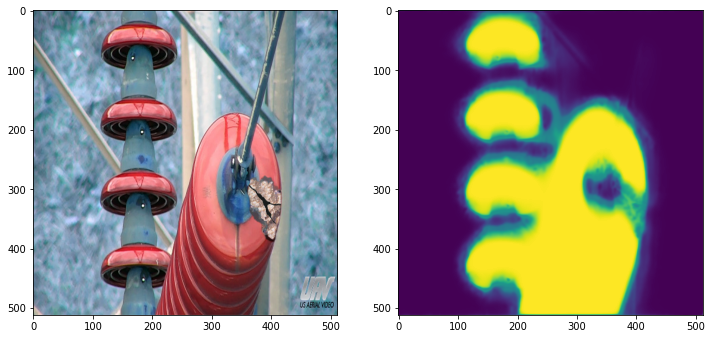

In [28]:
img = val_dataset.__getitem__(9)[0]
plt.figure(figsize=(12,12))
plt.subplot(121)
plt.imshow(img)
img_in = img.permute(2,0,1).unsqueeze(0).cuda()
pred = model(img_in)
plt.subplot(122)
plt.imshow(pred.permute(1,2,0)[:,:,0].detach().to("cpu"))


Maximal IoU at: p = 0.5
Maximal IoU: 0.732840895652771
tensor(0.)


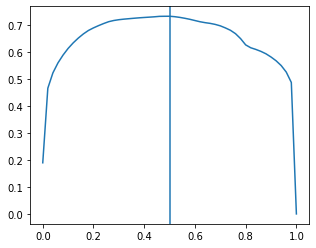

In [33]:
path1 = sorted(glob.glob(os.path.join("/content/drive/MyDrive/Transmission line insulators/Dataset/Dataset/Segmentation/val/in/*.jpg")))
path2 = sorted(glob.glob(os.path.join("/content/drive/MyDrive/Transmission line insulators/Dataset/Dataset/Segmentation/val/gt/*.jpg")))
d = np.zeros(7)
#aa = 0
#bb = 0
#p = .2

ious = []
ps = np.arange(0,1.02,step = 0.02)

with torch.no_grad():
  model.eval()
  for p in ps:
    preds = []
    gt1 = []

    for j in range(len(val_dataset)):
      image = torch.tensor(cv2.imread(path1[j]),dtype=torch.float32) / 255
      gt = torch.tensor(cv2.imread(path2[j], 0),dtype=torch.float32) / 255
      gt.unsqueeze_(0)
      y = gt
      y.unsqueeze_(0)
      image.unsqueeze_(0)
      x = image.permute(0,3,1,2)
      x = x.cuda()
      s = model(x)
      s = s.detach().cpu()
      s1 = s + 0.0
      s1[s1 < p] = 0
      preds.append(s1)
      gt1.append(y)
    #print(preds)
    ious.append(calc_iou(preds,gt1))

plt.figure(figsize = (5,4))
plt.plot(ps, ious)
plt.axvline(x = ps[np.argmax(ious)])

print('Maximal IoU at: p = {}'.format(ps[np.argmax(ious)]))
print('Maximal IoU: {}'.format(ious[np.argmax(ious)]))
print(calc_iou(preds,gt1))



# Classification using VGG
---
## Dataset and Dataloader classes

In [34]:
from os.path import join

def class_to_onehot(class_id, class_num):
  out = torch.zeros((1,class_num))
  out[1,class_id] = 1.0
  return out

class ClassDataset(Dataset):
    def __init__(self, transform = None, data_path = "", class_onehot = False):
        self.class_onehot = class_onehot
        self.paths = []
        self.paths_gt = []
        self.root_paths = sorted(glob.glob(join(data_path, "[0-9]*")))
        self.class_num = len(self.root_paths)
        self.path_class_dict = dict()
        class_id = 1
        for class_path in self.root_paths:
          current_paths = sorted(glob.glob(os.path.join(class_path, "*.jpg")))
          current_paths_gt = sorted(glob.glob(os.path.join(class_path, "gt/*.jpg")))
          for i, path in enumerate(current_paths):
            self.paths.append(path)
            self.paths_gt.append(current_paths_gt[i])
            self.path_class_dict[path] = class_id - 1
          class_id += 1

        self.transform = transform

    def __getitem__(self, index):
        sample  = cv2.imread(self.paths[index])
        mask = cv2.imread(self.paths_gt[index])
        sample = sample * mask
        
        if self.transform is not None:
            augmented = self.transform(image = sample)
            sample = torch.tensor(augmented['image'], dtype = torch.float32) / 255

        class_id = self.path_class_dict[self.paths[index]]

        if self.class_onehot:
          target = class_to_onehot(class_id, self.class_num)
        else:
          target = torch.tensor(class_id)
        
        return sample, target

    def __len__(self):
        return len(self.paths)

In [36]:
transform = Compose([ 
    VerticalFlip(p = 0.5),              
    RandomRotate90(p = 0.5),
    # OneOf([
    #     ElasticTransform(p = 0.5, alpha = 120, sigma = 120 * 0.05, alpha_affine = 120 * 0.03),
    #     GridDistortion(p = 0.5),
    #     OpticalDistortion(p = 1, distort_limit = 2, shift_limit = 0.5)                  
    #     ], p = 0.8),
    CLAHE(p = 0.8),
    RandomBrightnessContrast(p = 0.8),    
    RandomGamma(p = 0.8)])

transform1 = Compose([               
    RandomRotate90(p = 0.0),
  ])

batch_size = 3

class_train_dataset = ClassDataset(transform = transform, data_path = join("/content/drive/MyDrive/Transmission line insulators/Dataset/Dataset/Classification/train"))
class_val_dataset = ClassDataset(transform = transform1, data_path = join("/content/drive/MyDrive/Transmission line insulators/Dataset/Dataset/Classification/val"))
class_train_loader = DataLoader(class_train_dataset, batch_size = batch_size, shuffle = True, num_workers = 0)
class_train_loader_full = DataLoader(class_train_dataset, batch_size = len(class_train_dataset), shuffle = False, num_workers = 0)
class_val_loader = DataLoader(class_val_dataset, batch_size = len(class_val_dataset), shuffle = False, num_workers = 0)

In [37]:
for i in class_train_dataset:
  print(i)
  break

(tensor([[[0.2118, 0.2118, 0.2118],
         [0.2118, 0.2118, 0.2118],
         [0.2118, 0.2118, 0.2118],
         ...,
         [0.2118, 0.2118, 0.2118],
         [0.2118, 0.2118, 0.2118],
         [0.2118, 0.2118, 0.2118]],

        [[0.2118, 0.2118, 0.2118],
         [0.2118, 0.2118, 0.2118],
         [0.2118, 0.2118, 0.2118],
         ...,
         [0.2118, 0.2118, 0.2118],
         [0.2118, 0.2118, 0.2118],
         [0.2118, 0.2118, 0.2118]],

        [[0.2118, 0.2118, 0.2118],
         [0.2118, 0.2118, 0.2118],
         [0.2118, 0.2118, 0.2118],
         ...,
         [0.2118, 0.2118, 0.2118],
         [0.2118, 0.2118, 0.2118],
         [0.2118, 0.2118, 0.2118]],

        ...,

        [[0.2118, 0.2118, 0.2118],
         [0.2118, 0.2118, 0.2118],
         [0.2118, 0.2118, 0.2118],
         ...,
         [0.2118, 0.2118, 0.2118],
         [0.2118, 0.2118, 0.2118],
         [0.2118, 0.2118, 0.2118]],

        [[0.2118, 0.2118, 0.2118],
         [0.2118, 0.2118, 0.2118],
         [0

In [38]:
class VggDownBlock(nn.Module):
    def __init__(self, in_channels, mid_channels, out_channels, pooling = True, num_conv = 1, pool_kernel = 4):
        super().__init__()
        
        self.num_conv = num_conv

        self.convReLU = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace = True),
            nn.Conv2d(out_channels, out_channels, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace = True)
        )

        # self.convReLU2 = nn.Sequential(
        #     nn.Conv2d(in_channels, mid_channels, kernel_size = 3, padding = 1),
        #     nn.ReLU(inplace = True),
        #     nn.Conv2d(mid_channels, out_channels, kernel_size = 3, padding = 1),
        #     nn.ReLU()
        # )

        # self.convReLU3 = nn.Sequential(
        #     nn.Conv2d(in_channels, mid_channels, kernel_size = 3, padding = 1),
        #     nn.ReLU(),
        #     nn.Conv2d(mid_channels, mid_channels, kernel_size = 3, padding = 1),
        #     nn.ReLU(),
        #     nn.Conv2d(mid_channels, out_channels, kernel_size = 3, padding = 1),
        #     nn.ReLU()
        # )

        self.maxpool = nn.MaxPool2d(kernel_size = pool_kernel)
        
    def forward(self, seq):
        # B, C, H, W

        assert self.num_conv == 1, self.num_conv == 2 or self.num_conv == 3
        if self.num_conv == 1:
          seq = self.convReLU(seq)
        elif self.num_conv == 2:
          seq = self.convReLU2(seq)
        elif self.num_conv == 3:
          seq = self.convReLU3(seq)

        seq = self.maxpool(seq)

        return seq

class VGG(nn.Module):
    def __init__(self, num_classes):
      super().__init__()

      nb = 8

      self.downBlocks = nn.ModuleList()
      self.downBlocks.append(VggDownBlock(3, 3, nb, pool_kernel = 2))
      self.downBlocks.append(VggDownBlock(nb, nb, nb * 2, pool_kernel = 4))
      self.downBlocks.append(VggDownBlock(nb * 2, nb * 2, nb * 4, pool_kernel = 2))
      self.downBlocks.append(VggDownBlock(nb * 4, nb * 4, nb * 8, pool_kernel = 4))
      self.downBlocks.append(VggDownBlock(nb * 8, nb * 8, nb * 16, pool_kernel = 2))
      self.downBlocks.append(VggDownBlock(nb * 16, nb * 4, nb * 32, pool_kernel = 2))

      dims_flatten = (512 / (2 ** (len(self.downBlocks) + 2))) ** 2 * (nb * 32)

      self.finalBlock = nn.Sequential(nn.Flatten(),
                                     #nn.BatchNorm1d(int(dims_flatten)),
                                     nn.Linear(int(dims_flatten), 800),
                                     nn.ReLU(inplace = True),
                                     nn.Linear(800, num_classes))
                                     #nn.BatchNorm1d(int(num_classes)))
      
      self.initBN = nn.BatchNorm2d(3)
      
    def forward(self, input):

        for db in self.downBlocks:
          input = db(input)

        input = self.finalBlock(input)
        # input = input[:,0,:,:]

        return input

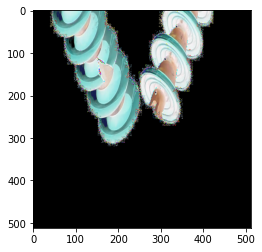

In [41]:
im = class_val_dataset.__getitem__(5)[0]
plt.imshow(im)

criterion = nn.CrossEntropyLoss()
cm = VGG(class_train_dataset.class_num).cuda()

In [42]:
torch.cuda.empty_cache()

In [43]:
#opt = torch.optim.Adam(cm.parameters(), lr = 0.002, weight_decay = 0.001, amsgrad = True)
opt = torch.optim.SGD(cm.parameters(), lr = 0.0076, momentum = 0.72, nesterov = True, weight_decay = 0.002)
#opt = torch.optim.Adamax(cm.parameters(), lr=0.002, betas=(0.9, 0.999), eps=1e-08, weight_decay = 0.001)

lmbda = lambda epoch: 0.98
scheduler = torch.optim.lr_scheduler.MultiplicativeLR(opt, lr_lambda = lmbda)

from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
experiment_title='Classification'
experiment_name = "{}@{}".format(experiment_title, datetime.now().strftime("%d.%m.%Y-%H:%M:%S"))
print('experiment_name:', experiment_name)
writer = SummaryWriter(log_dir=os.path.join("/content/drive/My Drive/tb", experiment_name))

experiment_name: Classification@23.12.2022-09:31:06


In [44]:
epochs = 20
losses = []
losses_val = []
losses_train = []
best_loss = 200
for n in tqdm(range(epochs)):
    n_iters = 0
    for batch in class_train_loader:
        cm.train()
        # if n_iters == 1:
        #   batch = next(iter(class_train_loader_full))
        x, y = batch
        x = x.permute(0,3,1,2)
        x = x.cuda()
        y = y.cuda()
        pred = cm(x)
        loss = criterion(pred, y)
        if math.isnan(loss.item()):
          break
        losses.append(loss.item())
        opt.zero_grad()
        loss.backward()
        opt.step()    
        scheduler.step()

        # Validation
        with torch.no_grad():
          cm.eval()
          x_val, y_val = next(iter(class_val_loader))
          pred_val = cm(x_val.permute(0,3,1,2).cuda())
          loss_val = criterion(pred_val, y_val.cuda())
          # iou_val = calc_iou_torch(pred_val, y_val)

        writer.add_scalar("train/loss", loss.item(), global_step = n * len(class_train_loader) + n_iters)
        writer.add_scalar("val/loss", loss_val.item(), global_step = n * len(class_train_loader) + n_iters)
        losses_train.append(loss.item())
        losses_val.append(loss_val.item())
        # writer.add_scalar("val/iou", loss_val.item(), global_step = n * len(class_train_loader) + n_iters)
        # if n_iters % 30 == 0:
        #     writer.add_image('train/photo_image', torchvision.utils.make_grid(x) * 0.5 + 0.5, n * len(train_loader) + n_iters)
        #     writer.add_image('train/map_image_prediction', torchvision.utils.make_grid(y_pred), n * len(train_loader) + n_iters)
        #     writer.add_image('train/map_image_groundtruth', torchvision.utils.make_grid(y), n * len(train_loader) + n_iters)
        n_iters += 1
        if loss_val < best_loss:
          torch.save(cm.state_dict(),'/content/drive/My Drive/bestClassificationNew3.pth')

100%|██████████| 20/20 [02:14<00:00,  6.73s/it]


In [64]:
cm.load_state_dict(torch.load('/content/drive/My Drive/bestClassificationNew3.pth'))
cm.eval()
sm = nn.Softmax(dim = 1)
x_val, y_val = next(iter(class_val_loader))
pred_val = sm(cm(x_val.permute(0,3,1,2).cuda())).argmax(dim = 1).to("cpu")

In [55]:
x_val[0]

tensor([[[0.0627, 0.0627, 0.0627],
         [0.0627, 0.0627, 0.0627],
         [0.0627, 0.0627, 0.0627],
         ...,
         [0.0627, 0.0627, 0.0627],
         [0.0627, 0.0627, 0.0627],
         [0.0627, 0.0627, 0.0627]],

        [[0.0627, 0.0627, 0.0627],
         [0.0627, 0.0627, 0.0627],
         [0.0627, 0.0627, 0.0627],
         ...,
         [0.0627, 0.0627, 0.0627],
         [0.0627, 0.0627, 0.0627],
         [0.0627, 0.0627, 0.0627]],

        [[0.0627, 0.0627, 0.0627],
         [0.0627, 0.0627, 0.0627],
         [0.0627, 0.0627, 0.0627],
         ...,
         [0.0627, 0.0627, 0.0627],
         [0.0627, 0.0627, 0.0627],
         [0.0627, 0.0627, 0.0627]],

        ...,

        [[0.0627, 0.0627, 0.0627],
         [0.0627, 0.0627, 0.0627],
         [0.0627, 0.0627, 0.0627],
         ...,
         [0.0627, 0.0627, 0.0627],
         [0.0627, 0.0627, 0.0627],
         [0.0627, 0.0627, 0.0627]],

        [[0.0627, 0.0627, 0.0627],
         [0.0627, 0.0627, 0.0627],
         [0.

In [65]:
y_val

tensor([0, 0, 0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3])

In [66]:
pred_val

tensor([0, 2, 2, 0, 0, 1, 1, 2, 2, 2, 2, 3, 3, 3])

In [56]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_val, pred_val)

array([[ 8,  0,  2,  0],
       [ 1,  8,  2,  0],
       [ 0,  1, 11,  0],
       [ 0,  0,  0, 12]])

1.   healthy
2.   broken_cap
3.   burned_corrosion
4.   missing_cap








```
                 good insulators   brokencap   burned_corrosion   missing_cap 

goodinsulators          8             0              2               0   

brokencap               1             8              2               0

burnedcorrosion         0             1             11               0

missingcap              0             0              0               12
```



In [62]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_val, pred_val,average='micro')


0.8666666666666667

In [63]:
from sklearn.metrics import precision_score, recall_score
recall_score(y_val, pred_val,average='micro')

0.8666666666666667

tensor(2)


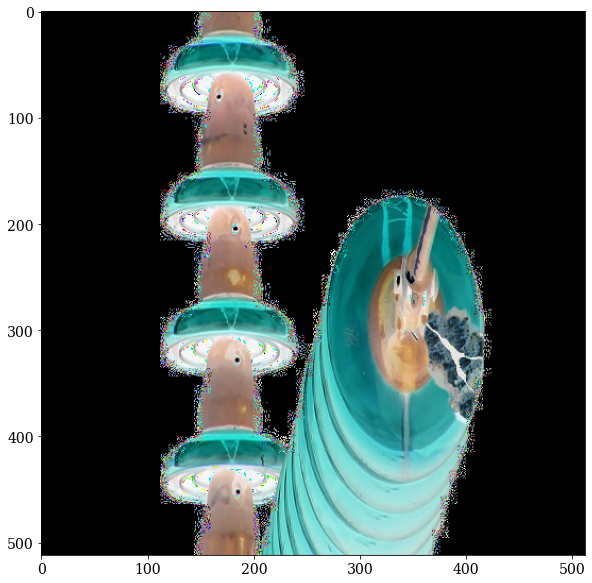

In [ ]:

h = 8
plt.figure(figsize=(12,10))
img = x_val[h,:,:,:]
plt.imshow(img)
print(y_val[h])

images_dir = '/content/drive/My Drive/'
plt.savefig(f"{images_dir}/ff.png")

In [59]:
assert len(pred_val) == len(y_val)
correct = 0
total = 0
for i in range(0, len(pred_val)):
  if torch.equal(pred_val[i], y_val[i].to("cpu")):
    total += 1
    correct += 1
  else:
    total += 1
print("Accuracy: ",correct/total)

Accuracy:  0.8666666666666667


In [61]:
# from matplotlib import rcParams
# rcParams['font.family'] = 'serif'
# rcParams['font.sans-serif'] = ['Times']
# rcParams['font.size'] = 14

In [60]:
# fig, ax = plt.subplots(figsize = (10,4))
# #ax.set_title('Loss, classifier training')
# plt.xlabel('Iteration')
# plt.ylabel('CE loss')
# plt.plot(losses_train[0:210], lw = 1.2, ls = 'dotted', color = 'gray', label = 'Training loss')
# plt.plot(losses_val[0:210], lw = 1.2, ls = 'solid', color = 'orange', label = 'Validation loss')
# ax.tick_params(direction='in', length = 4, width = 2, colors = 'black', grid_color = 'black', grid_alpha = 0.5)
# leg = plt.legend(fancybox = True, framealpha = 0.5, edgecolor = 'black')
# # leg = plt.legend()
# # leg.get_frame().set_edgecolor('b')
# plt.savefig('/content/drive/My Drive/classifierLoss.pdf', format = 'pdf')